## Roberta base sentiment model with word clouds 
- Model applied (https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment?text=%EB%82%9C+%EB%84%88%EA%B0%80+%EC%8B%AB%EC%96%B4)

In [1]:
import pandas as pd 
from tqdm import tqdm
tqdm.pandas()
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch.nn.functional as F
import spacy



/Users/cillian/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reviews_df = pd.read_csv('review_data/model_data.csv')
reviews_df = reviews_df.reset_index(drop=True)

In [3]:
reviews_df

index           name  rating   author_title   
0         0   Lost Weekend     4.4     Lucas Gahn  \
1         1   Lost Weekend     4.4  Susanne Kosch   
2         2   Lost Weekend     4.4   sahar sajedi   
3         3   Lost Weekend     4.4        Canberk   
4         5   Lost Weekend     4.4         Ella H   
...     ...            ...     ...            ...   
3018   3150  Dinatale Cafe     4.7     Susanne S.   
3019   3151  Dinatale Cafe     4.7   Vincent Vogt   
3020   3152  Dinatale Cafe     4.7     Vaiva Tepe   
3021   3153  Dinatale Cafe     4.7   Andy Baumann   
3022   3155  Dinatale Cafe     4.7       89456100   

                                            review_text  review_rating   
0     das café ist super und sehr stilvoll eingerich...            5.0  \
1     und jetzt mal halblang. könnte auch ein motto ...            5.0   
2           wässriger kaffee. nichts für nicht veganer.            2.0   
3     great place to study all day and drink some go...            5.0   
4     überfülltes studentencafe. nettes ambiente abe...            4.0   
...                                                 ...            ...   
3018  best coffee in town. best staff in town. simpl...            5.0   
3019  dolce vita at its best. a must stop for coffee..!            5.0   
3020                              very good cappuccino!            5.0   
3021                einfach herrlich ",italienisch" ...            5.0   
3022                                 sehr guter kaffee!            5.0   

            date language  
0     2023-10-09       de  
1     2023-10-09       de  
2     2023-10-04       de  
3     2023-09-28       en  
4     2023-09-20       de  
...          ...      ...  
3018  2019-06-26       en  
3019  2019-06-16       en  
3020  2019-06-16       it  
3021  2019-06-10       de  
3022  2019-06-01       de  

[3023 rows x 8 columns]

In [4]:

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

In [5]:
# function for roberta model
def classify_reviews(text):
    max_tokens = 512
    
    # tokenize the text and ensure it doesnt exceed max_tokens
    inputs = tokenizer(text, return_tensors = 'pt', max_length = max_tokens, truncation = True)
    
    # pass the tokenized input to the model
    with torch.no_grad():
        outputs = model(**inputs)
    # softmax to get probabilities    
    probs = torch.nn.functional.softmax(outputs.logits, dim = -1)
    # get the labels from the model config
    labels = model.config.id2label
    
    scores = {labels[i]: prob.item() for i, prob in  enumerate(probs[0])}
    
    return scores

In [6]:
scores_series = reviews_df['review_text'].progress_apply(classify_reviews)

100%|███████████████████████████████████████| 3023/3023 [05:33<00:00,  9.06it/s]


In [7]:
# Convert the dictionaries to a DF
scores_df = scores_df = scores_series.apply(pd.Series)

scores_df.columns = ['negative', 'neutral', 'positive']

reviews_df = pd.concat([reviews_df, scores_df], axis = 1)


In [8]:
#saving so i dont have to re-run model
reviews_df.to_csv('review_data/roberta_data.csv', index = False)

In [9]:
reviews_df

index           name  rating   author_title   
0         0   Lost Weekend     4.4     Lucas Gahn  \
1         1   Lost Weekend     4.4  Susanne Kosch   
2         2   Lost Weekend     4.4   sahar sajedi   
3         3   Lost Weekend     4.4        Canberk   
4         5   Lost Weekend     4.4         Ella H   
...     ...            ...     ...            ...   
3018   3150  Dinatale Cafe     4.7     Susanne S.   
3019   3151  Dinatale Cafe     4.7   Vincent Vogt   
3020   3152  Dinatale Cafe     4.7     Vaiva Tepe   
3021   3153  Dinatale Cafe     4.7   Andy Baumann   
3022   3155  Dinatale Cafe     4.7       89456100   

                                            review_text  review_rating   
0     das café ist super und sehr stilvoll eingerich...            5.0  \
1     und jetzt mal halblang. könnte auch ein motto ...            5.0   
2           wässriger kaffee. nichts für nicht veganer.            2.0   
3     great place to study all day and drink some go...            5.0   
4     überfülltes studentencafe. nettes ambiente abe...            4.0   
...                                                 ...            ...   
3018  best coffee in town. best staff in town. simpl...            5.0   
3019  dolce vita at its best. a must stop for coffee..!            5.0   
3020                              very good cappuccino!            5.0   
3021                einfach herrlich ",italienisch" ...            5.0   
3022                                 sehr guter kaffee!            5.0   

            date language  negative   neutral  positive  
0     2023-10-09       de  0.072393  0.133103  0.794504  
1     2023-10-09       de  0.402432  0.429644  0.167923  
2     2023-10-04       de  0.806672  0.145075  0.048253  
3     2023-09-28       en  0.022043  0.116644  0.861314  
4     2023-09-20       de  0.932403  0.051656  0.015941  
...          ...      ...       ...       ...       ...  
3018  2019-06-26       en  0.065482  0.114400  0.820118  
3019  2019-06-16       en  0.025826  0.111811  0.862363  
3020  2019-06-16       it  0.025424  0.086673  0.887903  
3021  2019-06-10       de  0.062306  0.088234  0.849460  
3022  2019-06-01       de  0.022236  0.082954  0.894810  

[3023 rows x 11 columns]

# Word Clouds with Roberta
- will only look at german and english
- remove stop words as these will be most common in text.
- lemmatize the words
- categorize into positive, neutral, and negative reviews.
- set up word clouds for overall and each venue 

In [10]:
en_de = reviews_df[reviews_df['language'].isin(['en', 'de'])]


In [11]:
en_de

index           name  rating   author_title   
0         0   Lost Weekend     4.4     Lucas Gahn  \
1         1   Lost Weekend     4.4  Susanne Kosch   
2         2   Lost Weekend     4.4   sahar sajedi   
3         3   Lost Weekend     4.4        Canberk   
4         5   Lost Weekend     4.4         Ella H   
...     ...            ...     ...            ...   
3017   3149  Dinatale Cafe     4.7      TobiasMud   
3018   3150  Dinatale Cafe     4.7     Susanne S.   
3019   3151  Dinatale Cafe     4.7   Vincent Vogt   
3021   3153  Dinatale Cafe     4.7   Andy Baumann   
3022   3155  Dinatale Cafe     4.7       89456100   

                                            review_text  review_rating   
0     das café ist super und sehr stilvoll eingerich...            5.0  \
1     und jetzt mal halblang. könnte auch ein motto ...            5.0   
2           wässriger kaffee. nichts für nicht veganer.            2.0   
3     great place to study all day and drink some go...            5.0   
4     überfülltes studentencafe. nettes ambiente abe...            4.0   
...                                                 ...            ...   
3017  unser stammlokal für einen guten kaffee am woc...            5.0   
3018  best coffee in town. best staff in town. simpl...            5.0   
3019  dolce vita at its best. a must stop for coffee..!            5.0   
3021                einfach herrlich ",italienisch" ...            5.0   
3022                                 sehr guter kaffee!            5.0   

            date language  negative   neutral  positive  
0     2023-10-09       de  0.072393  0.133103  0.794504  
1     2023-10-09       de  0.402432  0.429644  0.167923  
2     2023-10-04       de  0.806672  0.145075  0.048253  
3     2023-09-28       en  0.022043  0.116644  0.861314  
4     2023-09-20       de  0.932403  0.051656  0.015941  
...          ...      ...       ...       ...       ...  
3017  2019-07-06       de  0.039865  0.117227  0.842907  
3018  2019-06-26       en  0.065482  0.114400  0.820118  
3019  2019-06-16       en  0.025826  0.111811  0.862363  
3021  2019-06-10       de  0.062306  0.088234  0.849460  
3022  2019-06-01       de  0.022236  0.082954  0.894810  

[2896 rows x 11 columns]

In [12]:
import spacy

nlp_en = spacy.load('en_core_web_sm')
nlp_de = spacy.load('de_core_news_sm')


In [13]:
# I need to tokenize my text before removing stop words to get best results.
def tokenize(row):
    text = row['review_text']
    lang = row['language']
    
    if lang == 'en':
        doc = nlp_en(text)
    elif lang == 'de':
        doc = nlp_de(text)
    else:
        return text.split()
    
    return [token.text for token in doc]

In [14]:
en_de['review_text'] = en_de.progress_apply(tokenize, axis = 1)

100%|██████████████████████████████████████| 2896/2896 [00:13<00:00, 219.75it/s]
/var/folders/hm/lc2tr7v957lgz2xk_p_fhct40000gn/T/ipykernel_76648/3297155612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_de['review_text'] = en_de.progress_apply(tokenize, axis = 1)


In [29]:
#saving so i can compare with and without stop-words and lemmatiztion
en_de.to_csv('review_data/en_de_rwsl.csv', index = False)

In [30]:
# Fine-tuning word clouds by removing common words that dont add to word cloud

# Words in English to remove
english_stopwords_to_add = ["coffee", "place", "order", "munich"]
for word in english_stopwords_to_add:
    nlp_en.Defaults.stop_words.add(word)
    nlp_en.vocab[word].is_stop = True

# Words in German to remove
german_stopwords_to_add = ["kaffee", "mal"]
for word in german_stopwords_to_add:
    nlp_de.Defaults.stop_words.add(word)
    nlp_de.vocab[word].is_stop = True


# using spacy to remove stop words ill use a similar function as above to do this.
def remove_stopwords(tokens, lang):
    if lang == 'en':
        stop_words = nlp_en.Defaults.stop_words
    elif lang == 'de':
        stop_words = nlp_de.Defaults.stop_words
    else:
        return tokens
    
    return [token for token in tokens if token not in stop_words]

In [31]:
en_de['review_text'] = en_de.progress_apply(
    lambda row: remove_stopwords(
        row['review_text'].split() if isinstance(row['review_text'], str) else row['review_text'], 
        row['language']), 
    axis=1)

100%|████████████████████████████████████| 2896/2896 [00:00<00:00, 48008.98it/s]
/var/folders/hm/lc2tr7v957lgz2xk_p_fhct40000gn/T/ipykernel_76648/4197029575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_de['review_text'] = en_de.progress_apply(


In [32]:
def lemmatize(tokens, lang):
    if lang == 'en':
        nlp = nlp_en
    elif lang == 'de':
        nlp = nlp_de
    else:
        return tokens 
    
    # Convert the list of tokens back to text
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Extract lemmas for each token and return
    return [token.lemma_ for token in doc]

In [33]:
#Calling the lemmatize function
en_de['review_text'] = en_de.progress_apply(
    lambda row: lemmatize(
        row['review_text'].split() if isinstance(row['review_text'], str) else row['review_text'], 
        row['language']), 
    axis=1)

100%|██████████████████████████████████████| 2896/2896 [00:10<00:00, 283.09it/s]
/var/folders/hm/lc2tr7v957lgz2xk_p_fhct40000gn/T/ipykernel_76648/3890627529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_de['review_text'] = en_de.progress_apply(


In [34]:
#saving so i can compare with and without stop-words and lemmatiztion
en_de.to_csv('review_data/en_de_rsl.csv', index = False)

In [35]:
threshold = 0.4
positive_reviews = en_de[en_de['positive'] > threshold]['review_text']
neutral_reviews = en_de[en_de['neutral'] > threshold]['review_text']
negative_reviews = en_de[en_de['negative'] > threshold]['review_text']


In [36]:
positive_text = ' '.join([' '.join(review) for review in positive_reviews])
neutral_text = ' '.join([' '.join(review) for review in neutral_reviews])
negative_text = ' '.join([' '.join(review) for review in negative_reviews])


In [37]:
positive_text

'Café Super Stilvoll einrichten -- Student Nähe liegen Uni genießen einfach Laptop arbeiten -- Terrasse Café bieten -- essen -- great study day drink good . vegan product . thank , think meet deadline . great work laptop weekend grab . excellent cold brew . gemütlich Atmosphäre - fein Sortiment kuch Snack -- exzellent -- Aufpreis verschieden milchalternativ auswähl 👌 Leitung Laden John gerne regelmäßig lost \U0001faf6 📖 ✨ great service drink .     time quality .     atmosphere nice work people .     unfortunately experience phone computer able connect - house wifi , able catch eduroam signal door computer . cool spot . service ok . know suppose bring ready . . price accord " market " . good vegan sandwich . matcha latte ok . lively , great price . perfect location grab work . night convert venue spot live music . like come visit . nice spot cocktail ! warm indoor , outdoor seating available . excellent , aperol decent . , red wine par . Vegan Super Lecker -- amazing feeling , universit

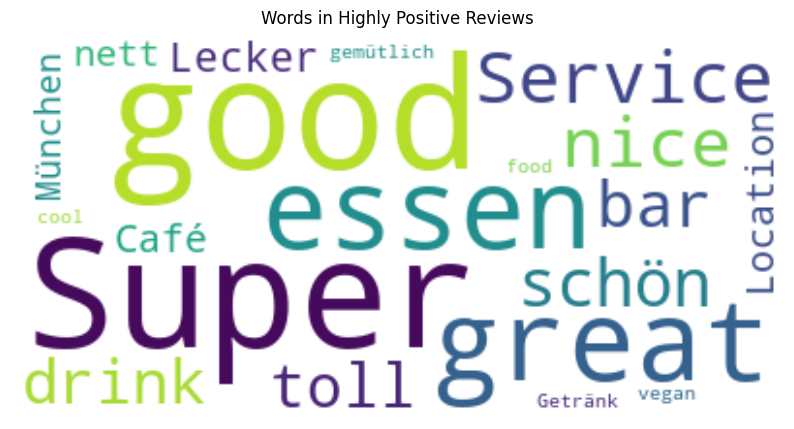

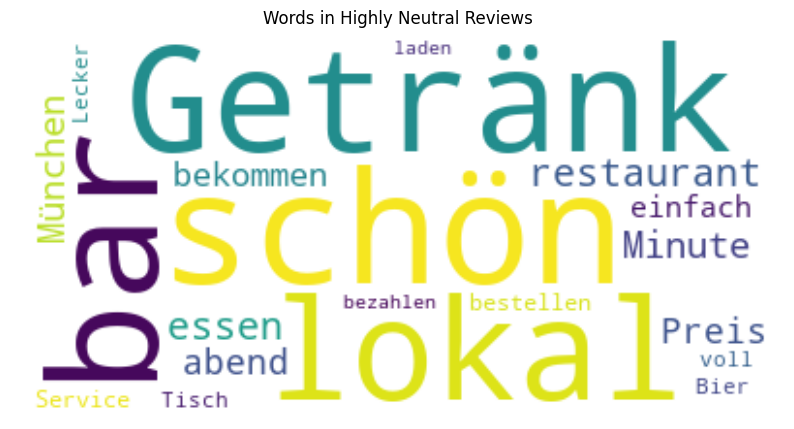

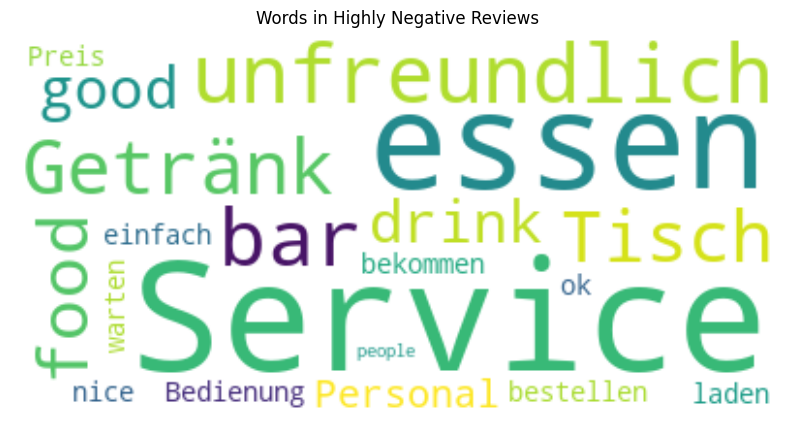

In [38]:
# general wordcloud for all businesses
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wordcloud = WordCloud(max_font_size=80,
                          max_words=20,
                          background_color="white",
                          colormap = 'viridis',
                          
                          prefer_horizontal = 0.9,
                          margin = 10).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds
generate_wordcloud(positive_text, "Words in Highly Positive Reviews")
generate_wordcloud(neutral_text, "Words in Highly Neutral Reviews")
generate_wordcloud(negative_text, "Words in Highly Negative Reviews")

In [25]:
# now we want to generate word clouds for each venue 


In [26]:
en_de

index           name  rating   author_title   
0         0   Lost Weekend     4.4     Lucas Gahn  \
1         1   Lost Weekend     4.4  Susanne Kosch   
2         2   Lost Weekend     4.4   sahar sajedi   
3         3   Lost Weekend     4.4        Canberk   
4         5   Lost Weekend     4.4         Ella H   
...     ...            ...     ...            ...   
3017   3149  Dinatale Cafe     4.7      TobiasMud   
3018   3150  Dinatale Cafe     4.7     Susanne S.   
3019   3151  Dinatale Cafe     4.7   Vincent Vogt   
3021   3153  Dinatale Cafe     4.7   Andy Baumann   
3022   3155  Dinatale Cafe     4.7       89456100   

                                            review_text  review_rating   
0     [Café, Super, Stilvoll, einrichten, --, Studen...            5.0  \
1     [Halblang, --, Motto, --, Hang, Loose, --, \n ...            5.0   
2                          [Wässriger, --, veganer, --]            2.0   
3     [great, study, day, drink, good, ., vegan, pro...            5.0   
4     [überfüllt, Studentencafe, --, nettes, Ambient...            4.0   
...                                                 ...            ...   
3017  [stammlokal, gut, Wochenende, --, zudem, nett,...            5.0   
3018  [good, town, ., good, staff, town, ., simply, ...            5.0   
3019                [dolce, vita, well, ., stop, .., !]            5.0   
3021   [einfach, herrlich, --, --, italienisch, --, --]            5.0   
3022                                               [--]            5.0   

            date language  negative   neutral  positive  
0     2023-10-09       de  0.072393  0.133103  0.794504  
1     2023-10-09       de  0.402432  0.429644  0.167923  
2     2023-10-04       de  0.806672  0.145075  0.048253  
3     2023-09-28       en  0.022043  0.116644  0.861314  
4     2023-09-20       de  0.932403  0.051656  0.015941  
...          ...      ...       ...       ...       ...  
3017  2019-07-06       de  0.039865  0.117227  0.842907  
3018  2019-06-26       en  0.065482  0.114400  0.820118  
3019  2019-06-16       en  0.025826  0.111811  0.862363  
3021  2019-06-10       de  0.062306  0.088234  0.849460  
3022  2019-06-01       de  0.022236  0.082954  0.894810  

[2896 rows x 11 columns]

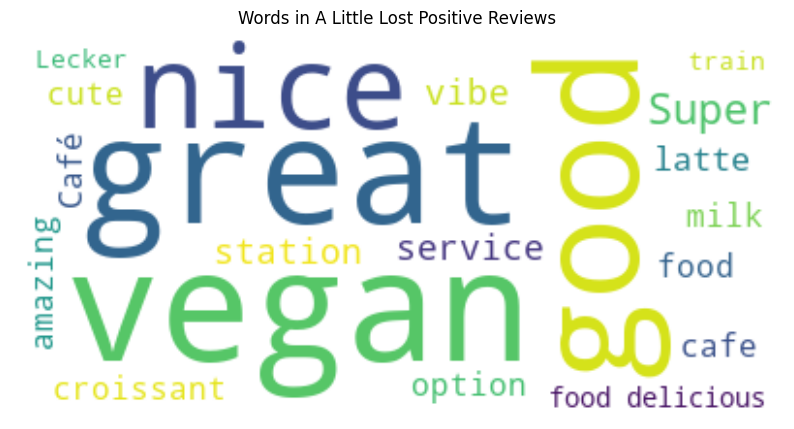

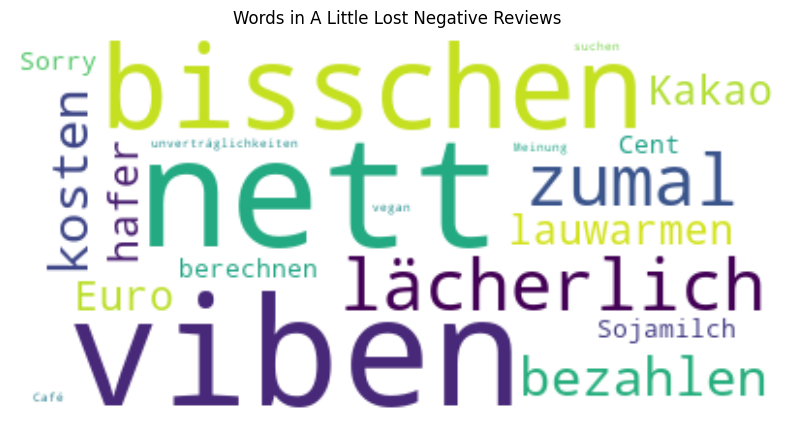

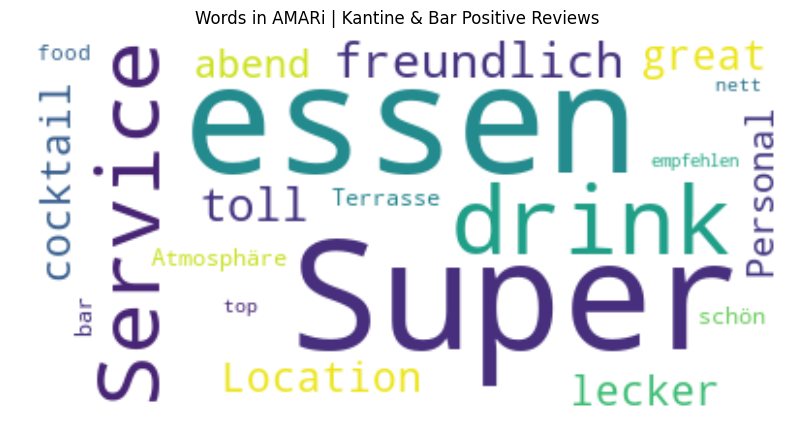

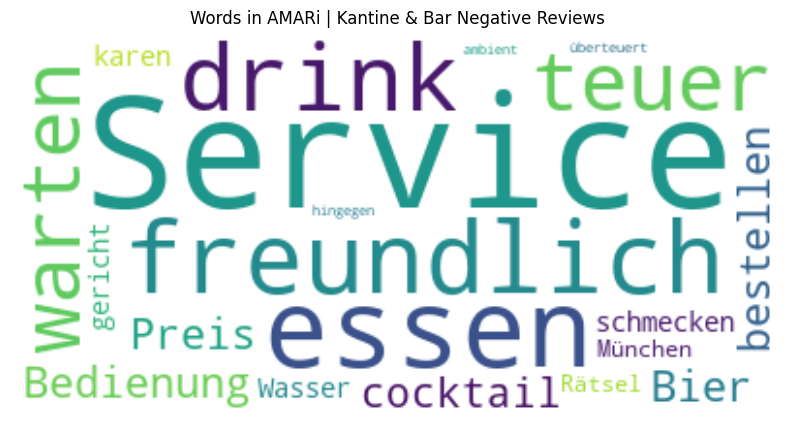

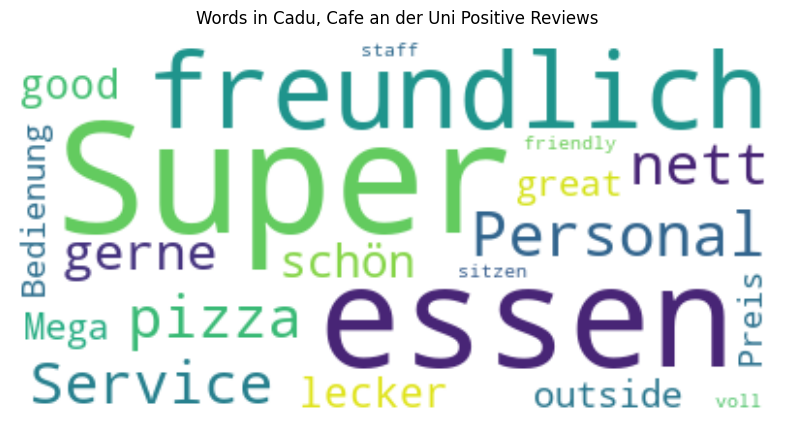

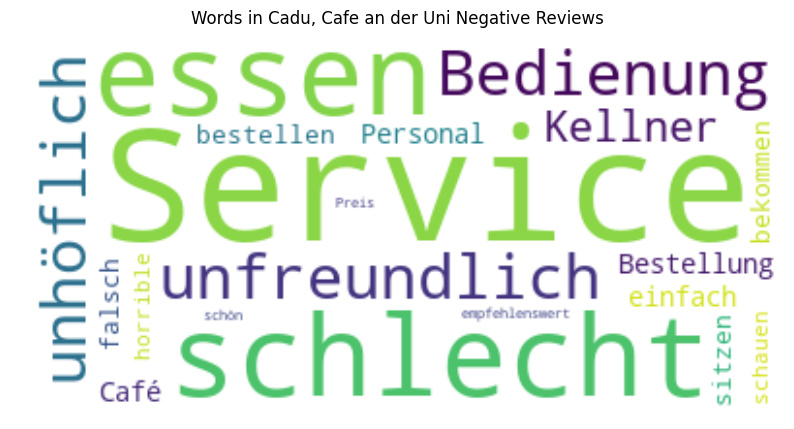

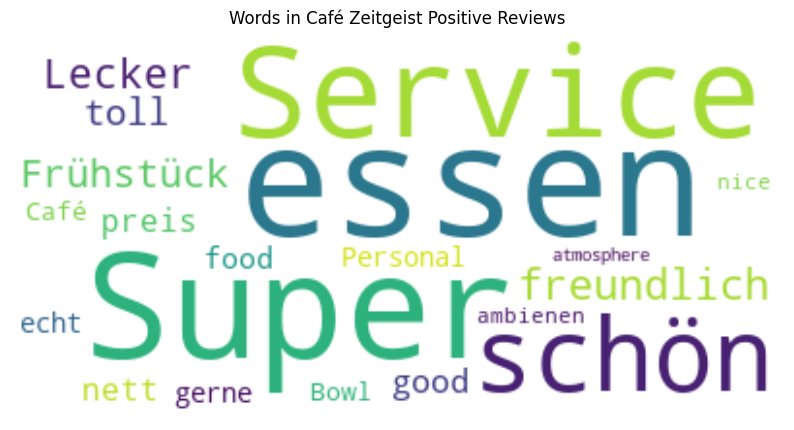

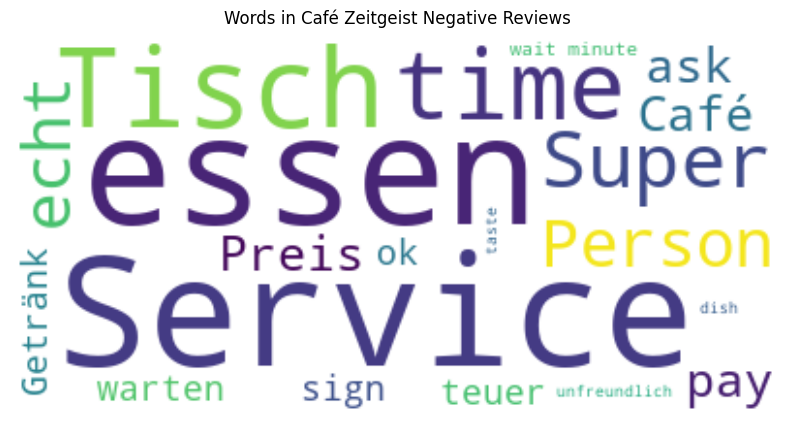

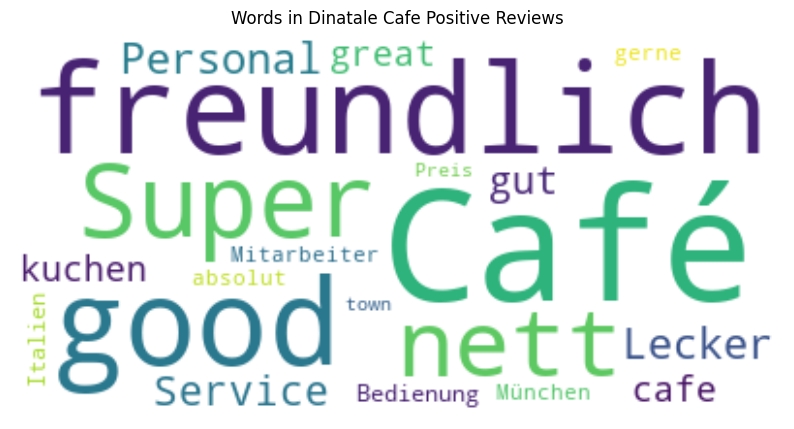

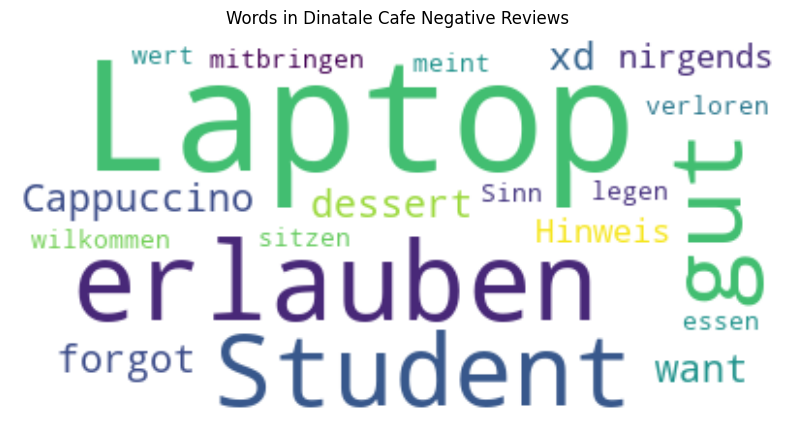

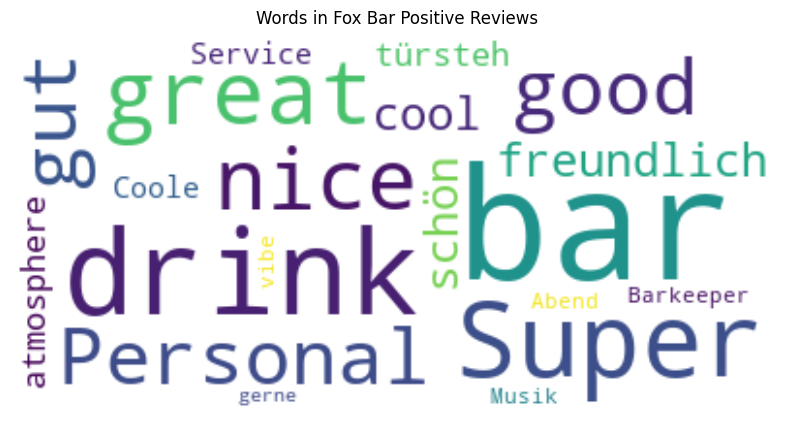

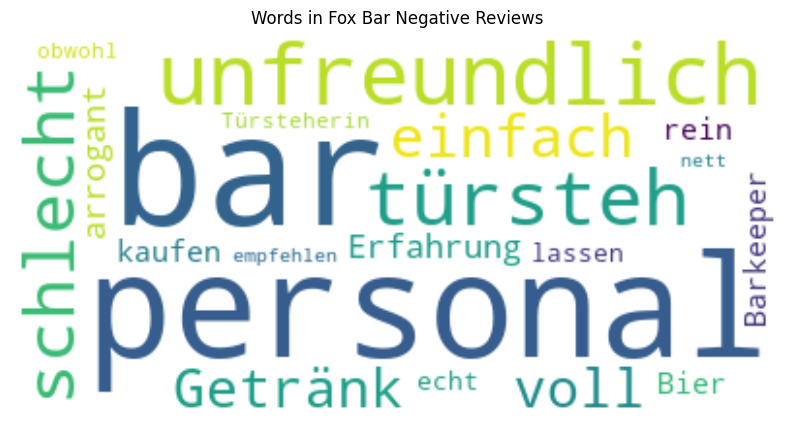

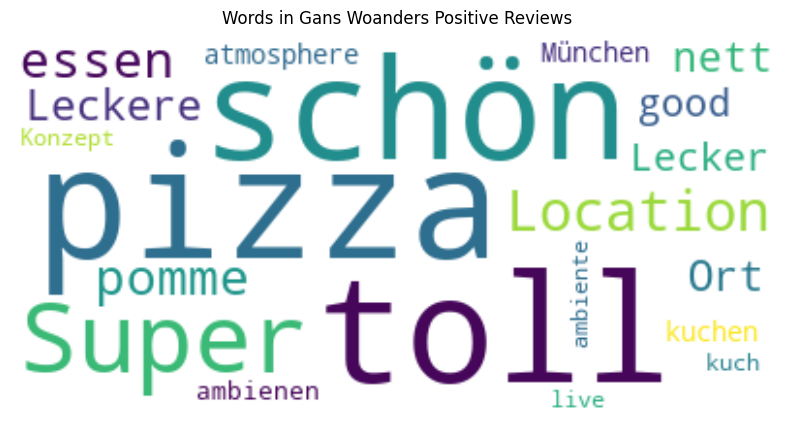

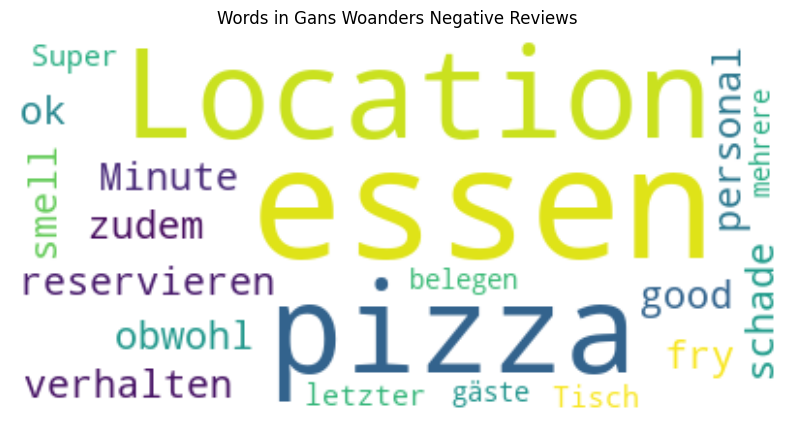

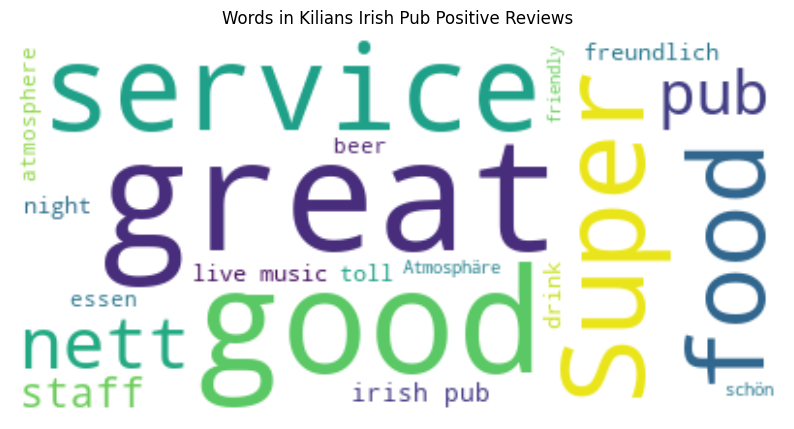

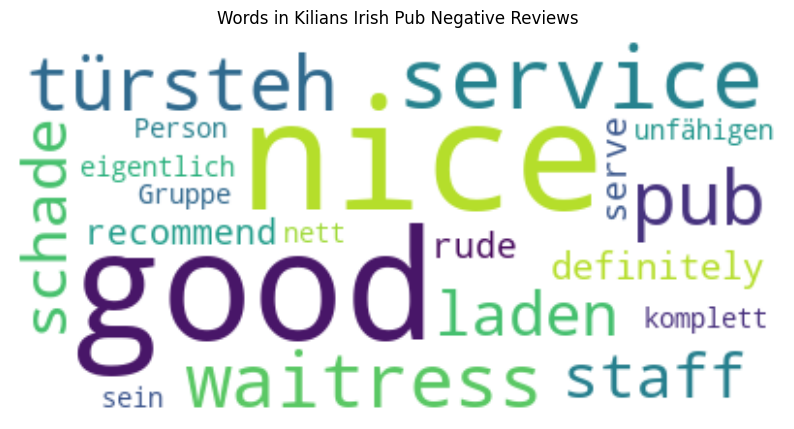

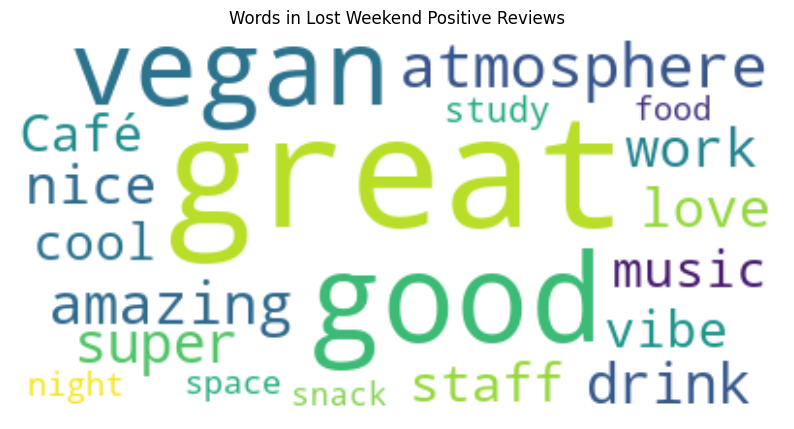

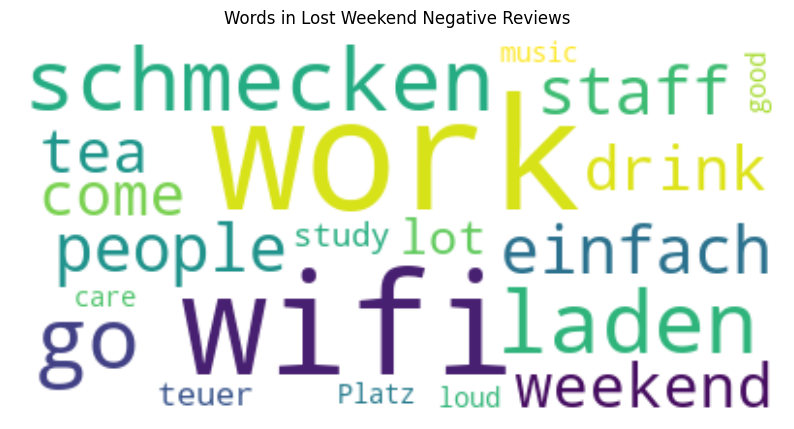

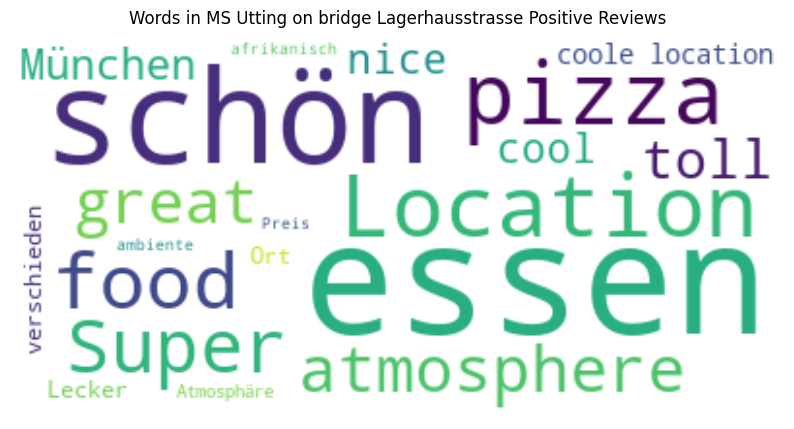

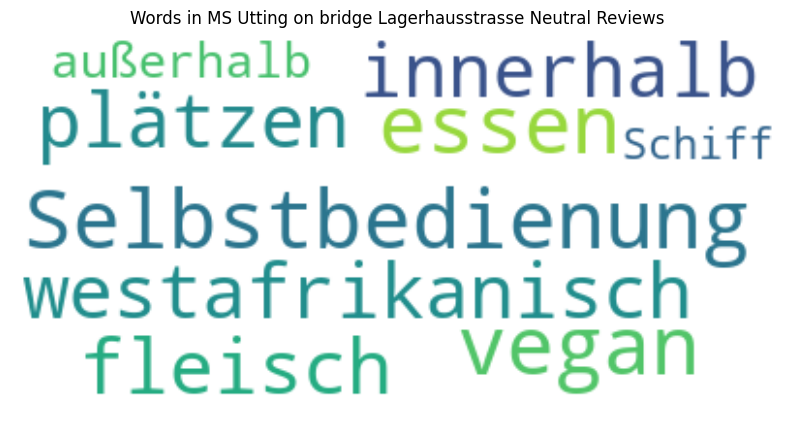

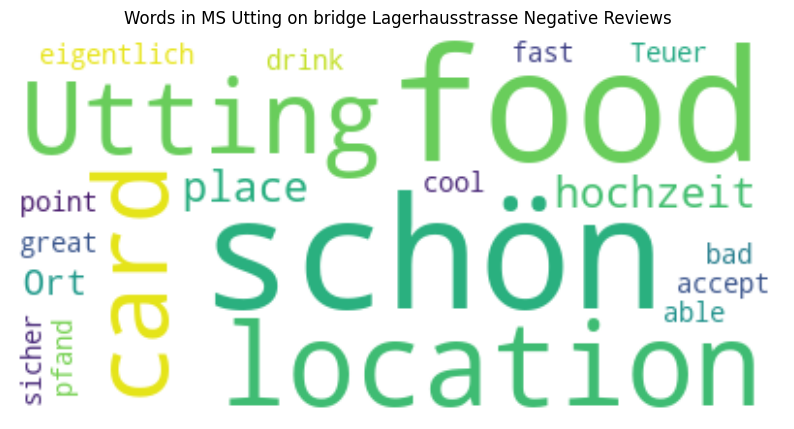

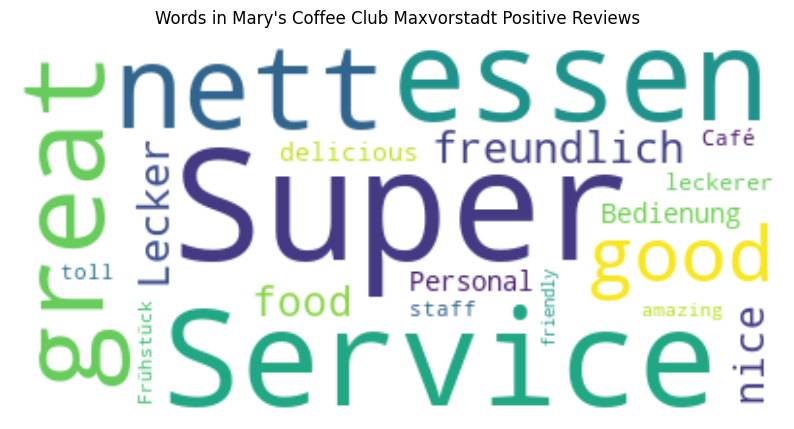

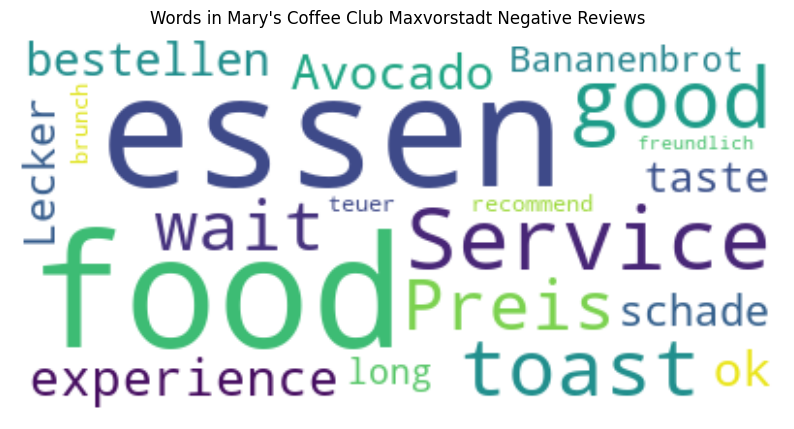

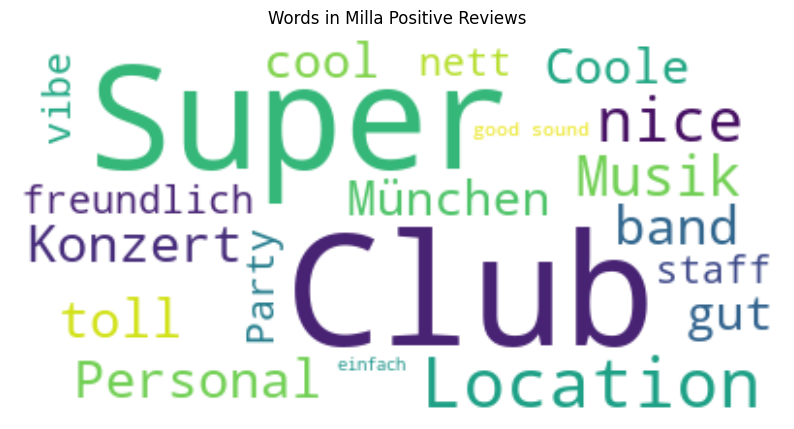

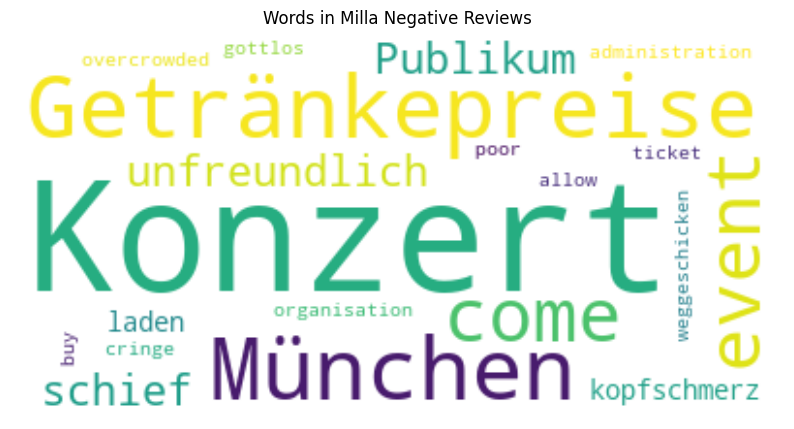

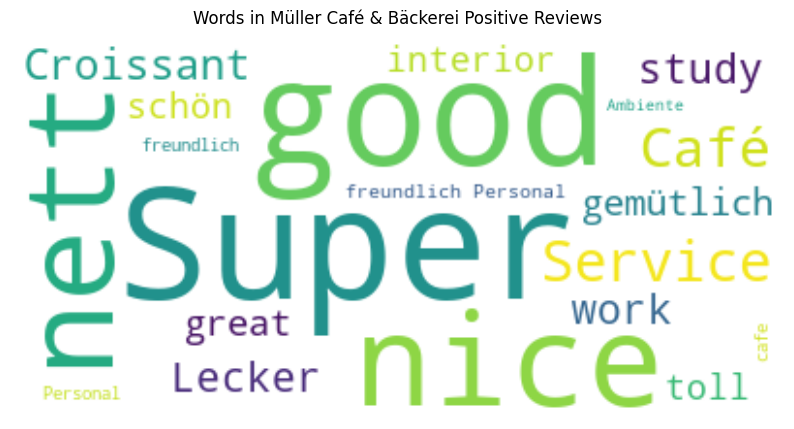

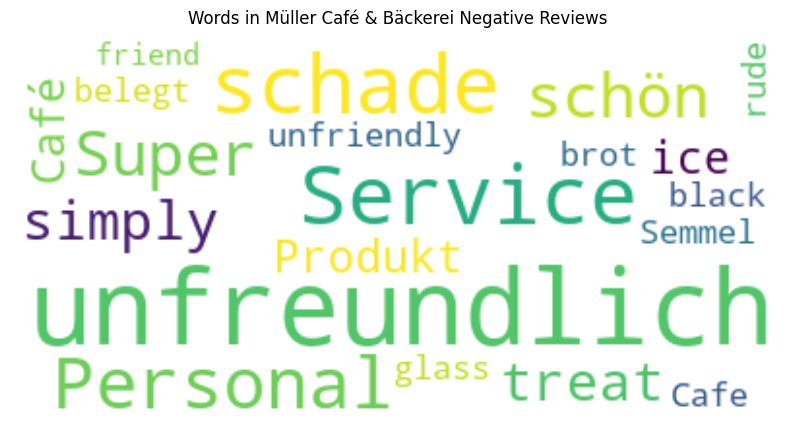

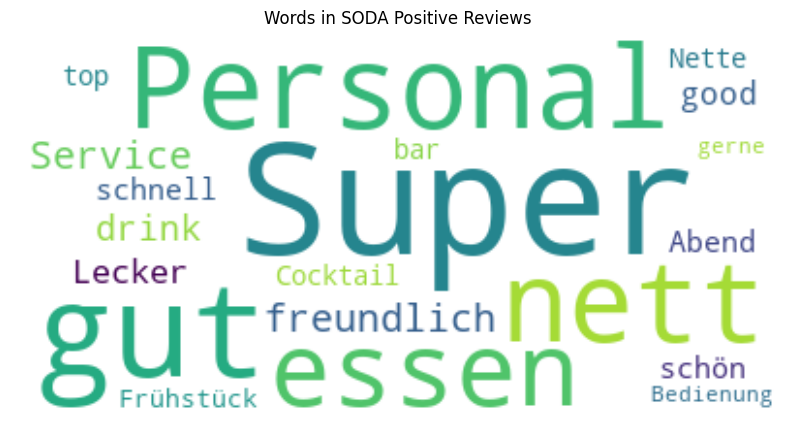

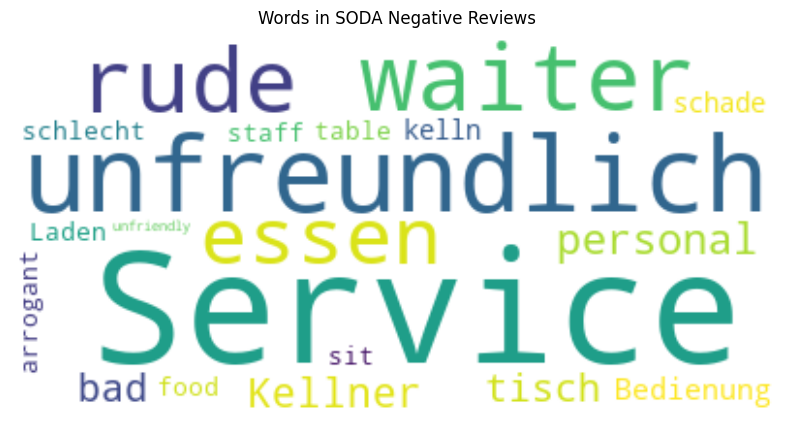

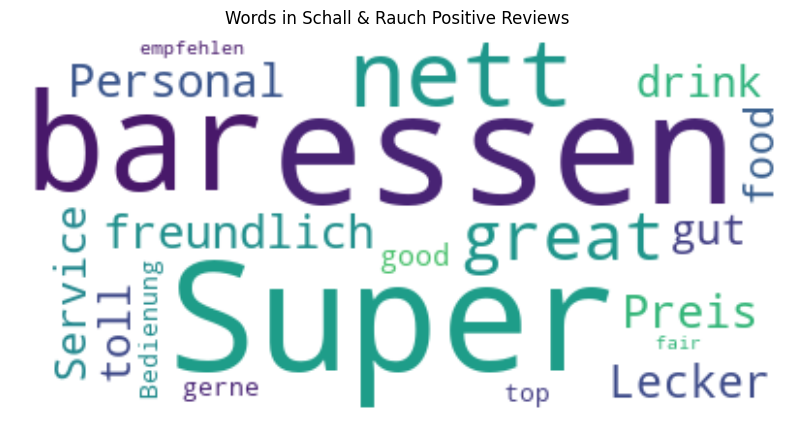

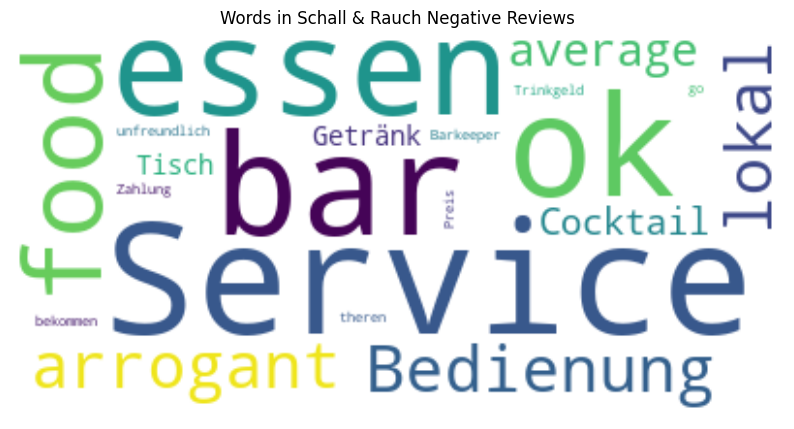

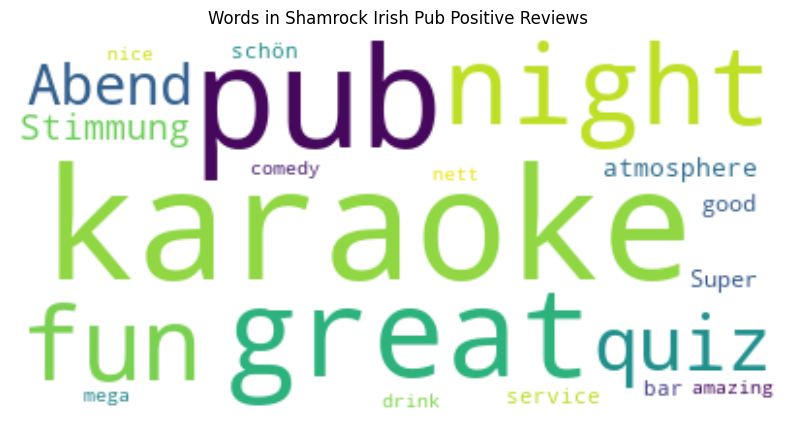

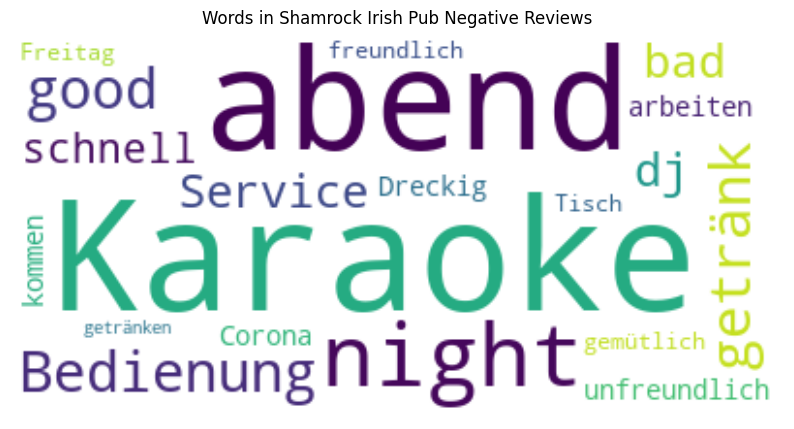

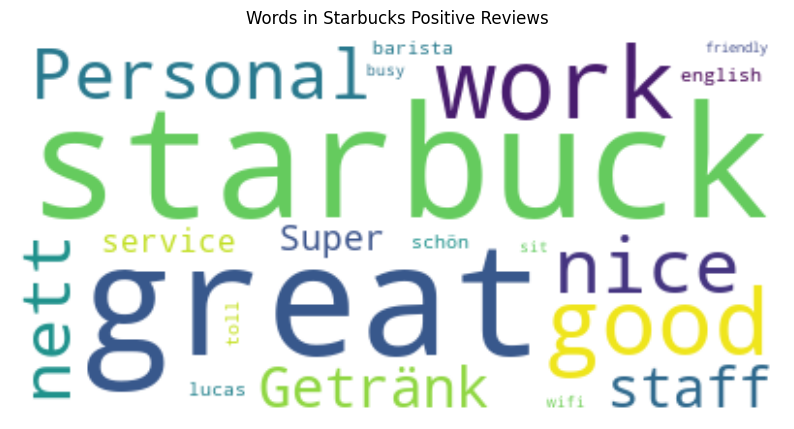

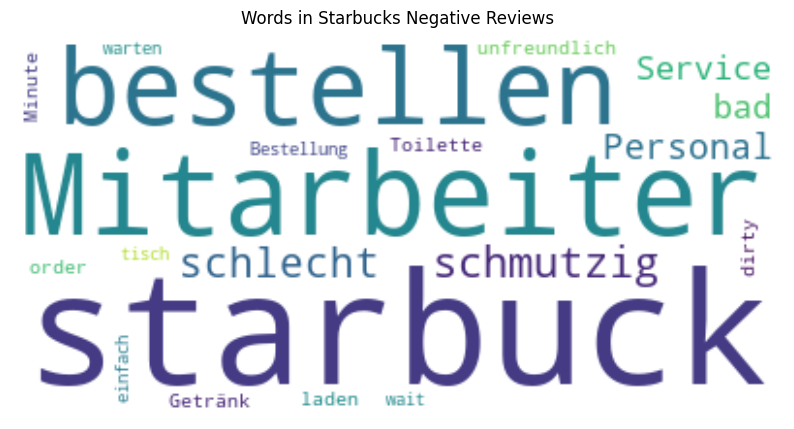

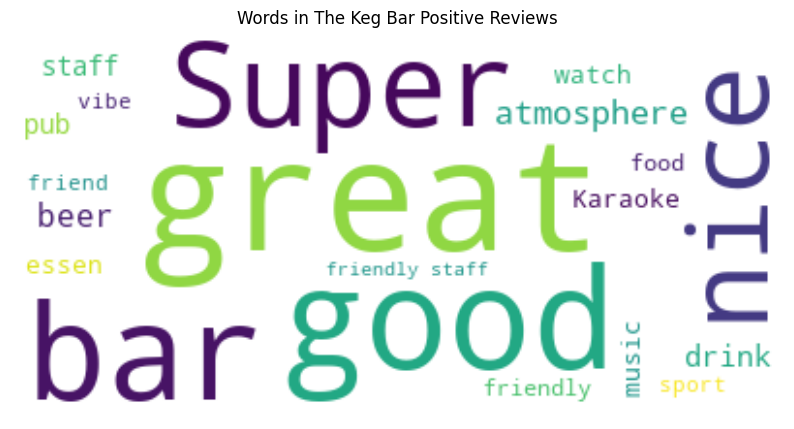

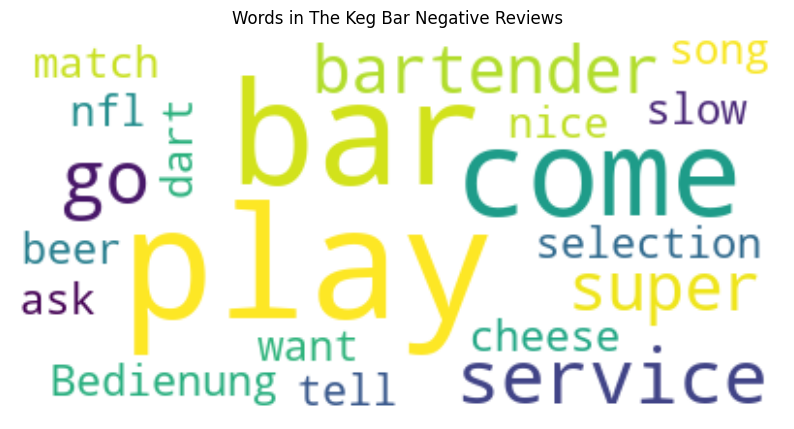

In [27]:
# Group by venue
grouped = en_de.groupby('name')  # Assuming 'name' is the column with the venue names.

# For storing combined texts for each sentiment for each venue
venue_positive_texts = {}
venue_neutral_texts = {}
venue_negative_texts = {}


# Loop over each venue group
for venue_name, group in grouped:
    # Filter reviews based on sentiment thresholds for the current venue group
    positive_reviews = group[group['positive'] > threshold]['review_text']
    neutral_reviews = group[group['neutral'] > threshold]['review_text']
    negative_reviews = group[group['negative'] > threshold]['review_text']
    
    # Generate the combined text for each sentiment category for the current venue
    venue_positive_texts[venue_name] = ' '.join([' '.join(review) for review in positive_reviews])
    venue_neutral_texts[venue_name] = ' '.join([' '.join(review) for review in neutral_reviews])
    venue_negative_texts[venue_name] = ' '.join([' '.join(review) for review in negative_reviews])

    # Optionally, generate word clouds for each venue and sentiment
    if venue_positive_texts[venue_name]:
        generate_wordcloud(venue_positive_texts[venue_name], f"Words in {venue_name} Positive Reviews")
    if venue_neutral_texts[venue_name]:
        generate_wordcloud(venue_neutral_texts[venue_name], f"Words in {venue_name} Neutral Reviews")
    if venue_negative_texts[venue_name]:
        generate_wordcloud(venue_negative_texts[venue_name], f"Words in {venue_name} Negative Reviews")
